# ResNet ImageNet Fine-Tuning

This experiment will involve fine-tuning a pretrained ResNet model, as opposed to an Xception model. The model will take cetacean images and attempt to classify quality. The same preprocessing and data splitting strageties implemented in the Xception experiments will be used.

In [1]:
!nvidia-smi

Sat Aug 17 00:57:45 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.28.03              Driver Version: 560.28.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           On  |   00000000:89:00.0 Off |                    0 |
| N/A   34C    P0             43W /  300W |       1MiB /  32768MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

2024-08-17 00:57:55.036518: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-17 00:57:55.054100: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-17 00:57:55.059674: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-17 00:57:55.072804: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-17 00:57:56.924250: W tensorflow/compiler/tf2

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [58]:
import numpy as np
import keras
from keras import layers, regularizers
import matplotlib.pyplot as plt
import os
from PIL import Image
import pandas as pd
from keras.callbacks import EarlyStopping
import math
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from time import time
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, balanced_accuracy_score
from concurrent.futures import ThreadPoolExecutor, as_completed

In [8]:
# load images
def load_img(path):
    img = Image.open(path)
    img = img.resize((128,128))
    np_img = np.array(img)/255
    return os.path.basename(path), np_img
def load_images_into_dict(img_dir):
    imgs = {}
    paths = [os.path.join(img_dir, img) for img in os.listdir(img_dir)]

    num_workers = 8
    
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        future_to_img = {executor.submit(load_img, path): path for path in paths}

        for future in as_completed(future_to_img):
            img_name, img = future.result()
            imgs[img_name] = img

    return imgs
    
t0 = time()
home = "/home/jctactay/koa_scratch/images"

imgs = load_images_into_dict(home)
print(f"Done in {time() - t0: .3f}s")

Done in  174.961s


In [9]:
# load/reconcile labels
cols = ["species","image","distinctiveness","quality"]
labels1 = pd.read_csv('pifsc_labels_detail.csv')[cols]
labels1[['quality', 'distinctiveness']] = labels1[['distinctiveness', 'quality']]

cols = ["species","filename","distinctiveness","quality"]
labels2 = pd.read_csv('pifsc_labels2.csv')[cols]
labels2.columns = ["species","image","distinctiveness","quality"]

labels = pd.concat([labels1, labels2]).reset_index(drop=True)

In [10]:
print(len(imgs))

3613


In [11]:
is_na = labels.quality.isna()
labels = labels.loc[~is_na]
labels = labels.drop_duplicates(subset='image', keep='first')

img_names = labels.image.tolist()
features = {k: v for k, v in imgs.items() if k in img_names}
assert len(features) == len(labels)

In [12]:
labels.quality.value_counts()

quality
2    1479
1    1116
3     991
Name: count, dtype: int64

In [13]:
# check for nans
for k, v in zip(features.keys(), features.values()):
    if np.isnan(v.any()):
        print(k)

In [14]:
Y = labels.quality
if min(np.unique(Y)) != 0:
    for i in range(len(Y)):
        Y.iat[i] -= 1
print(np.unique(Y))
X = np.array([features[i] for i in labels.image])
print(len(Y))
print(len(X))
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, stratify=Y_train, random_state=42)

[0 1 2]
3586
3586


In [15]:
# weights per sample instead of per class
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(Y_train), y=Y_train)
print(class_weights)
class_weights_dict = dict(zip(np.unique(Y_train), class_weights))
sample_weights = np.array([class_weights_dict[label] for label in Y_train])
sample_weights

[1.07174888 0.80834273 1.20504202]


array([1.20504202, 1.07174888, 0.80834273, ..., 0.80834273, 1.20504202,
       1.20504202])

In [16]:
# load pretrained model
base_model = keras.applications.ResNet50(
    weights='imagenet',
    input_shape=(128,128,3),
    include_top=False)
# freeze base model
base_model.trainable = False

2024-08-17 01:04:49.487549: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31134 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:89:00.0, compute capability: 7.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [45]:
print(len(Y_train.value_counts()))

3


In [46]:
# modify input layer
inputs = keras.Input(shape=(128,128,3))
# scale_layer = keras.layers.Rescaling(scale=1/127.5, offset=-1)
# x = scale_layer(inputs)
# inference mode so weights do not update)
x = base_model(inputs, training=False)
# new trainable layers
x = keras.layers.GlobalAveragePooling2D()(x)
# x = keras.layers.Dense(1024, activation='relu')(x)
# x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(len(Y_train.value_counts()), activation='softmax')(x)
model = keras.Model(inputs, outputs)
model.summary(show_trainable=True)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_6 (InputLayer)  │ (None, 128, 128, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ resnet50 (Functional)       │ (None, 4, 4, 2048)    │ 23,587,712 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_5  │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_9 (Dense)             │ (None, 256)           │    524,544 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_5 (Dropout)         │ (None, 256)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_10 (Dense)            │ (None, 3)             │        771 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 24,113,027 (91.98 MB)

 Trainable params: 525,315 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [47]:
callback = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")

In [19]:
def plot_history(history):
    num_subplots = len(history.history.keys())//2
    fig, ax = plt.subplots(num_subplots)
    for i, metric in enumerate(history.history.keys()):
        ax[i%num_subplots].plot(history.history[metric], label=metric)
        ax[i%num_subplots].legend()

## Initial fit

In [48]:
model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs=15, batch_size=16, validation_data=(X_val, Y_val), sample_weight=sample_weights, callbacks=callback)

Epoch 1/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 22s 82ms/step - accuracy: 0.3475 - loss: 1.1958 - val_accuracy: 0.3431 - val_loss: 1.1085
Epoch 2/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.3352 - loss: 1.1048 - val_accuracy: 0.3821 - val_loss: 1.0832
Epoch 3/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3660 - loss: 1.0938 - val_accuracy: 0.3431 - val_loss: 1.0889
Epoch 4/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3392 - loss: 1.0970 - val_accuracy: 0.3278 - val_loss: 1.0810
Epoch 5/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.3466 - loss: 1.0847 - val_accuracy: 0.3459 - val_loss: 1.0868
Epoch 6/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3643 - loss: 1.0892 - val_accuracy: 0.4086 - val_loss: 1.0720
Epoch 7/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.3699 - loss: 1.0812 - val_accuracy: 0.3473 - val_loss: 1.0794
Epoch 8/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.3708 - loss: 1.0809 - val_acc

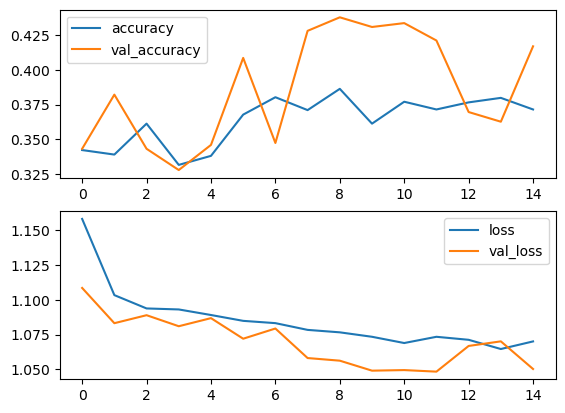

In [49]:
plot_history(history)

In [50]:
pred_soft = model.predict(X_test)
preds = []
for i in pred_soft:
    preds.append(np.argmax(i))
print(classification_report(Y_test, preds))

23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step
              precision    recall  f1-score   support

           0       0.42      0.59      0.49       224
           1       0.43      0.13      0.20       296
           2       0.37      0.60      0.46       198

    accuracy                           0.40       718
   macro avg       0.41      0.44      0.38       718
weighted avg       0.41      0.40      0.36       718



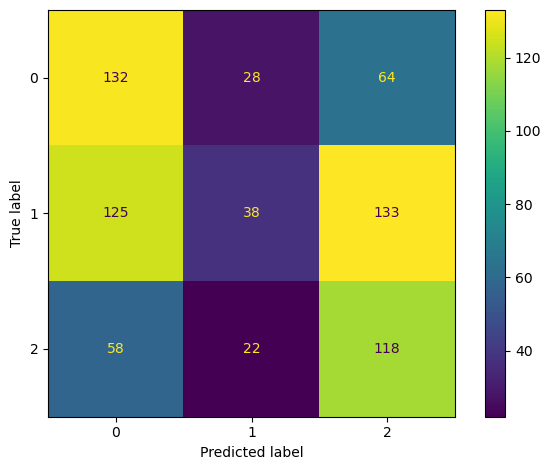

In [51]:
cm = confusion_matrix(Y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.tight_layout()

## Top 4 layers

In [52]:
# unfreeze top 4 base layers
for layer in base_model.layers[-4:]:
    layer.trainable = True
model.summary(show_trainable=True)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_6 (InputLayer)  │ (None, 128, 128, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ resnet50 (Functional)       │ (None, 4, 4, 2048)    │ 23,587,712 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_5  │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_9 (Dense)             │ (None, 256)           │    524,544 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_5 (Dropout)         │ (None, 256)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_10 (Dense)            │ (None, 3)             │        771 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 25,163,659 (95.99 MB)

 Trainable params: 1,580,035 (6.03 MB)

 Non-trainable params: 22,532,992 (85.96 MB)

 Optimizer params: 1,050,632 (4.01 MB)

In [53]:
callback = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss", start_from_epoch=5)

In [54]:
# top 4 layers unfrozen
model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

epochs=20
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=32, validation_data=(X_val, Y_val), sample_weight=sample_weights, callbacks=callback)

Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 23s 153ms/step - accuracy: 0.4382 - loss: 1.0630 - val_accuracy: 0.4156 - val_loss: 1.0468
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.4322 - loss: 1.0377 - val_accuracy: 0.4212 - val_loss: 1.0427
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.4186 - loss: 1.0340 - val_accuracy: 0.4198 - val_loss: 1.0360
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.4424 - loss: 1.0163 - val_accuracy: 0.4212 - val_loss: 1.0303
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.4302 - loss: 1.0212 - val_accuracy: 0.4198 - val_loss: 1.0226
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.4449 - loss: 1.0073 - val_accuracy: 0.4324 - val_loss: 1.0138
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4483 - loss: 1.0127 - val_accuracy: 0.4435 - val_loss: 1.0108
Epoch 8/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.4481 - loss: 1.0094 - val_accuracy: 0.4561 -

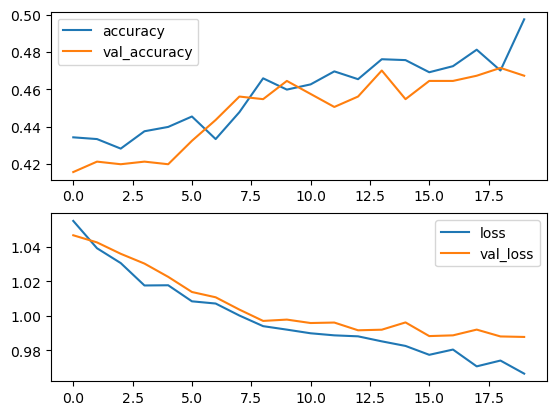

In [55]:
plot_history(history)

In [56]:
pred_soft = model.predict(X_test)
preds = []
for i in pred_soft:
    preds.append(np.argmax(i))
print(classification_report(Y_test, preds))

23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step
              precision    recall  f1-score   support

           0       0.44      0.64      0.52       224
           1       0.47      0.25      0.33       296
           2       0.46      0.54      0.49       198

    accuracy                           0.45       718
   macro avg       0.46      0.48      0.45       718
weighted avg       0.46      0.45      0.43       718



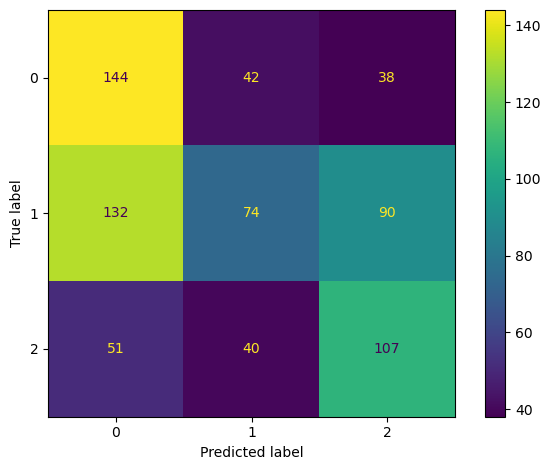

In [57]:
cm = confusion_matrix(Y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.tight_layout()

In [62]:
balanced_accuracy_score(Y_test, preds)

0.4777537277537278